# PERSONAL CAPSTONE

Dataset:[Hotel Reviews](https://data.world/datafiniti/hotel-reviews)

What can be done with this data.

* What are the bottom and top states for hotel reviews by average rating?
* What is the correlation between a state’s population and their number of hotel reviews?
* What is the correlation between a state’s tourism budget and their number of hotel reviews?
* Fit a regression model on reviews and score to see which words are more indicative to a higher/lower score
* Perform a sentiment analysis on the reviews
* Find correlation between reviewer's nationality and scores.
* Beautiful and informative visualization on the dataset.
* Clustering hotels based on reviews
* Simple recommendation engine to the guest who is fond of a special characteristic of hotel.


## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from IPython.display import Image
from IPython.display import display
import seaborn as sns

import time

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.feature_selection import f_classif, f_regression, SelectKBest


import nltk 
from nltk import FreqDist 
nltk.download('stopwords') # run this one time

import spacy 
import gensim 
from gensim import corpora 
from gensim.corpora import Dictionary

import warnings
# Suppress annoying harmless error.
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

#import plotly.plotly as py
#import plotly.tools as tls


# libraries for visualization 
import pyLDAvis 
import pyLDAvis.gensim 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Checkout/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data

In [2]:
df_original  = pd.read_csv('datafiniti_hotel_reviews.csv')
print('The shape of the data is:', df_original.shape)

The shape of the data is: (10000, 26)


In [3]:
display(df_original.head(1))

,id,dateadded,dateupdated,address,categories,primarycategories,city,country,keys,latitude,...,reviews_rating,reviews_sourceurls,reviews_text,reviews_title,reviews_usercity,reviews_userprovince,reviews_username,sourceurls,websites,location
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)


In [4]:
df_original.columns

Index(['id', 'dateadded', 'dateupdated', 'address', 'categories',
       'primarycategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalcode', 'province', 'reviews_date', 'reviews_dateseen',
       'reviews_rating', 'reviews_sourceurls', 'reviews_text', 'reviews_title',
       'reviews_usercity', 'reviews_userprovince', 'reviews_username',
       'sourceurls', 'websites', 'location'],
      dtype='object')

In [5]:
df_original.dtypes

id                       object
dateadded                object
dateupdated              object
address                  object
categories               object
primarycategories        object
city                     object
country                  object
keys                     object
latitude                float64
longitude               float64
name                     object
postalcode               object
province                 object
reviews_date             object
reviews_dateseen         object
reviews_rating          float64
reviews_sourceurls       object
reviews_text             object
reviews_title            object
reviews_usercity         object
reviews_userprovince     object
reviews_username         object
sourceurls               object
websites                 object
location                 object
dtype: object

In [6]:
# Count nulls 
null_count = df_original.isnull().sum()
null_count[null_count>0]

reviews_text               1
reviews_title              1
reviews_usercity        5836
reviews_userprovince    7295
dtype: int64

## Data Cleaning

Here I am going to begin the data cleaning. I will beging with the obvious number of null values that are only in the reviews_usercity and reviews_userprovince columns. 

In [7]:
# Here I am coping the original dataset into df0 so that I leave the original data alone. 
df0 = df_original

In [8]:
## Assumptions: We are just going to Assume that people who didn't fill out the city and State Value 
#Lived in the Same State and City 
## For the empty values in reviews_userprovince replace with the value of the hotel's province 
## For the empty values in reviews_usercity replace with the value of hotel's city
df0['reviews_userprovince'].fillna(value = df0['province'], inplace=True)
df0['reviews_usercity'].fillna(value = df0['city'], inplace=True)

In [9]:
# These are the columns that will not be helpful during the analysis
df0.loc[0:4, ['id','keys','reviews_sourceurls','sourceurls','websites','location']]

,id,keys,reviews_sourceurls,sourceurls,websites,location
0,AVwc252WIN2L1WUfpqLP,us/ca/ranchosantafe/5921valenciacir/359754519,https://www.hotels.com/hotel/125419/reviews%20/,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
1,AVwc252WIN2L1WUfpqLP,us/ca/ranchosantafe/5921valenciacir/359754519,https://www.hotels.com/hotel/125419/reviews%20/,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
2,AVwc252WIN2L1WUfpqLP,us/ca/ranchosantafe/5921valenciacir/359754519,https://www.hotels.com/hotel/125419/reviews%20/,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
3,AVwdOclqIN2L1WUfti38,us/md/hanover/7520teaguerd/-2043779672,https://www.tripadvisor.com/Hotel_Review-g4118...,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,POINT(-76.716341 39.155929)
4,AVwdOclqIN2L1WUfti38,us/md/hanover/7520teaguerd/-2043779672,https://www.tripadvisor.com/Hotel_Review-g4118...,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,POINT(-76.716341 39.155929)


In [10]:
df0 = df0.drop(['id','keys','reviews_sourceurls','sourceurls','websites','location'],1)

In [11]:
df0.head(1)

,dateadded,dateupdated,address,categories,primarycategories,city,country,latitude,longitude,name,postalcode,province,reviews_date,reviews_dateseen,reviews_rating,reviews_text,reviews_title,reviews_usercity,reviews_userprovince,reviews_username
0,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2013-11-14T00:00:00Z,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,Rancho Santa Fe,CA,Paula


In [12]:
## convert dates to date time object
df0['dateadded']=df0['dateadded'].str[:10]
df0['dateadded'] = pd.to_datetime(df0['dateadded'])

df0['dateupdated']=df0['dateupdated'].str[:10]
df0['dateupdated'] = pd.to_datetime(df0['dateupdated'])

df0['reviews_date']=df0['reviews_date'].str[:10]
df0['reviews_date'] = pd.to_datetime(df0['reviews_date'])

df0['reviews_dateseen']=df0['reviews_dateseen'].str[:10]
df0['reviews_dateseen'] = pd.to_datetime(df0['reviews_dateseen'])

In [13]:
df0.dtypes

dateadded               datetime64[ns]
dateupdated             datetime64[ns]
address                         object
categories                      object
primarycategories               object
city                            object
country                         object
latitude                       float64
longitude                      float64
name                            object
postalcode                      object
province                        object
reviews_date            datetime64[ns]
reviews_dateseen        datetime64[ns]
reviews_rating                 float64
reviews_text                    object
reviews_title                   object
reviews_usercity                object
reviews_userprovince            object
reviews_username                object
dtype: object

### Cleaning the Categories and Primary Category Columns

In [14]:
# I can see that many of these category names appear to be duplicates and need to be cleaned. 
df0.categories.value_counts().head(10)

Hotels,Hotel                                  1905
Hotel,Hotels                                   403
Hotel,Hotels Motels                            233
Hotels,Hotels and motels,Hotel                 148
Hotels,Lodging,Motels,Hotel                    141
Hotels,Casinos,Resorts,Resort,Casino,Hotel     139
Hotels,Boutique Hotels,Hotel                   128
Hotels,Lodging,Hotel                           108
Hotels,Resort,Spa,Hotel,Hotel Pool              99
Hotels,Corporate Lodging,Lodging,Hotel          98
Name: categories, dtype: int64

In [15]:
# This is a function to remove the unnecessary endings from words. 
def endchop(thestring, ending):
    if thestring.endswith(ending):
        return thestring[:-len(ending)]
    return thestring

In [16]:
# Empty dataset to put the cleaned up data
clean_data = pd.DataFrame(index=range(0,10000), columns=['categories', 'primarycategories'])

In [17]:
for i in range(len(df0)):
    
    single_list = []
    # I split each row into only words after making them lower case and removing spaces
    for each in df0.categories[i].lower().replace(' ',',').split(','):
        # Ignoring 'and'
        if each == 'and':
            continue
        # Ignoring '&'
        elif each == '&':
            continue
        # With the remaining words, remove the extra 's' on the end
        else:
            # Append these single words to a list
            single_list.append(endchop(each, 's'))
    
    #Then take the single words and reduce it to the unique words with set() then make it a list so that the words
    # can be joined back into a string. 
    clean_data.categories[i] = ', '.join(list(set(single_list)))

In [18]:
# Here is the result of cleaned up data
clean_data.categories.value_counts().head(10)

hotel                               2308
motel, hotel                        1035
lodging, hotel, motel                587
motel, hotel, lodging                359
lodging, hotel, corporate, motel     278
lodging, hotel, corporate            235
lodging, hotel                       183
motel, hotel, corporate, lodging     169
casino, hotel, resort                142
hotel, boutique                      128
Name: categories, dtype: int64

In [19]:
# What the clean database looks like
clean_data.head()

,categories,primarycategories
0,"motel, hotel, resort, reservation",NaN
1,"motel, hotel, resort, reservation",NaN
2,"motel, hotel, resort, reservation",NaN
3,"agencie, motel, hotel, travel, management, bureau",NaN
4,"agencie, motel, hotel, travel, management, bureau",NaN


In [20]:
# I can see that many of these primary category names appear to be duplicates and need to be cleaned also. 
df0.primarycategories.value_counts().head(10)

Accommodation & Food Services                                    9928
Arts Entertainment & Recreation                                    45
Healthcare & Social Assistance,Accommodation & Food Services       18
Wholesale Trade,Accommodation & Food Services                       7
Accommodation & Food Services,Arts Entertainment & Recreation       1
Utilities                                                           1
Name: primarycategories, dtype: int64

In [21]:
for i in range(len(df0)):

    single_list = []
    # I did multiple split and joins on this data because of the unnecessary &, ',', and white space
    the_and = ''.join(df0.primarycategories[i].lower().split('&'))
    comma = ' '.join(the_and.split(','))
    double = ' '.join(comma.split('  '))
    # Once I had each word separated by one space, I ignored the words that always went together
    for item in double.split(' '):
        if item == 'services':
            continue
        elif item == 'arts':
            continue 
        elif item == 'social':
            continue
        else:
            # I took these remaining words at added them to a list
            single_list.append(item)

    # I joined the cleaned list of words into a single string and entered them into the clean_data
    clean_data.primarycategories[i] = ', '.join(single_list)

In [22]:
# Here is the result of cleaned up data
clean_data.primarycategories.value_counts().head(10)

accommodation, food                               9928
entertainment, recreation                           45
healthcare, assistance, accommodation, food         18
wholesale, trade, accommodation, food                7
utilities                                            1
accommodation, food, entertainment, recreation       1
Name: primarycategories, dtype: int64

In [23]:
# What the clean category database looks like
clean_data.head()

,categories,primarycategories
0,"motel, hotel, resort, reservation","accommodation, food"
1,"motel, hotel, resort, reservation","accommodation, food"
2,"motel, hotel, resort, reservation","accommodation, food"
3,"agencie, motel, hotel, travel, management, bureau","accommodation, food"
4,"agencie, motel, hotel, travel, management, bureau","accommodation, food"


## Creating Clean, Reorganized DataFrame1

In [24]:
# Here are the old df0 column names
df0.columns

Index(['dateadded', 'dateupdated', 'address', 'categories',
       'primarycategories', 'city', 'country', 'latitude', 'longitude', 'name',
       'postalcode', 'province', 'reviews_date', 'reviews_dateseen',
       'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_usercity',
       'reviews_userprovince', 'reviews_username'],
      dtype='object')

In [25]:
# Empty dataset to put the reorganized and cleaned up data
df1 = pd.DataFrame(index=range(0,10000), columns=['reviews_rating', 'reviews_title', 'reviews_text', 'hotel_name',
                                                 'clean_categories', 'primary_categories', 'address', 'city', 'province',
                                                 'country', 'postalcode', 'latitude', 'longitude', 'dateadded', 
                                                  'dateupdated', 'reviews_date', 'reviews_dateseen', 'reviews_usercity',
                                                  'reviews_userprovince', 'reviews_username'])

In [26]:
# For the columns with the same name and data I filled them with the info from df0
for each in df1.columns:
    if each in df0.columns:
        df1[each] = df0[each]

In [27]:
# Here is what the df1 look like so far
df1.head()

,reviews_rating,reviews_title,reviews_text,hotel_name,clean_categories,primary_categories,address,city,province,country,postalcode,latitude,longitude,dateadded,dateupdated,reviews_date,reviews_dateseen,reviews_usercity,reviews_userprovince,reviews_username
0,5.0,Best romantic vacation ever!!!!,Our experience at Rancho Valencia was absolute...,NaN,NaN,NaN,5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2013-11-14,2016-08-03,Rancho Santa Fe,CA,Paula
1,5.0,Sweet sweet serenity,Amazing place. Everyone was extremely warm and...,NaN,NaN,NaN,5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2014-07-06,2016-08-02,Rancho Santa Fe,CA,D
2,5.0,Amazing Property and Experience,We booked a 3 night stay at Rancho Valencia to...,NaN,NaN,NaN,5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2015-01-02,2016-11-15,Rancho Santa Fe,CA,Ron
3,2.0,"Never again...beware, if you want sleep.",Currently in bed writing this for the past hr ...,NaN,NaN,NaN,7520 Teague Rd,Hanover,MD,US,21076,39.155929,-76.716341,2015-11-28,2018-09-10,2016-05-15,2016-05-21,Richmond,VA,jaeem2016
4,5.0,ALWAYS GREAT STAY...,I live in Md and the Aloft is my Home away fro...,NaN,NaN,NaN,7520 Teague Rd,Hanover,MD,US,21076,39.155929,-76.716341,2015-11-28,2018-09-10,2016-07-09,2016-07-31,Laurel,MD,MamaNiaOne


In [28]:
# Filling in the columns where I changed the column name or inserted my cleaned data. 
df1.hotel_name = df0.name
df1.clean_categories = clean_data.categories
df1.primary_categories = clean_data.primarycategories

In [29]:
# Final clean df1
df1.head()

,reviews_rating,reviews_title,reviews_text,hotel_name,clean_categories,primary_categories,address,city,province,country,postalcode,latitude,longitude,dateadded,dateupdated,reviews_date,reviews_dateseen,reviews_usercity,reviews_userprovince,reviews_username
0,5.0,Best romantic vacation ever!!!!,Our experience at Rancho Valencia was absolute...,Rancho Valencia Resort Spa,"motel, hotel, resort, reservation","accommodation, food",5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2013-11-14,2016-08-03,Rancho Santa Fe,CA,Paula
1,5.0,Sweet sweet serenity,Amazing place. Everyone was extremely warm and...,Rancho Valencia Resort Spa,"motel, hotel, resort, reservation","accommodation, food",5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2014-07-06,2016-08-02,Rancho Santa Fe,CA,D
2,5.0,Amazing Property and Experience,We booked a 3 night stay at Rancho Valencia to...,Rancho Valencia Resort Spa,"motel, hotel, resort, reservation","accommodation, food",5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2015-01-02,2016-11-15,Rancho Santa Fe,CA,Ron
3,2.0,"Never again...beware, if you want sleep.",Currently in bed writing this for the past hr ...,Aloft Arundel Mills,"agencie, motel, hotel, travel, management, bureau","accommodation, food",7520 Teague Rd,Hanover,MD,US,21076,39.155929,-76.716341,2015-11-28,2018-09-10,2016-05-15,2016-05-21,Richmond,VA,jaeem2016
4,5.0,ALWAYS GREAT STAY...,I live in Md and the Aloft is my Home away fro...,Aloft Arundel Mills,"agencie, motel, hotel, travel, management, bureau","accommodation, food",7520 Teague Rd,Hanover,MD,US,21076,39.155929,-76.716341,2015-11-28,2018-09-10,2016-07-09,2016-07-31,Laurel,MD,MamaNiaOne


## Exploring Data

In [30]:
## Working with clean Data 
df = df1 

### Distributions of features in Data 

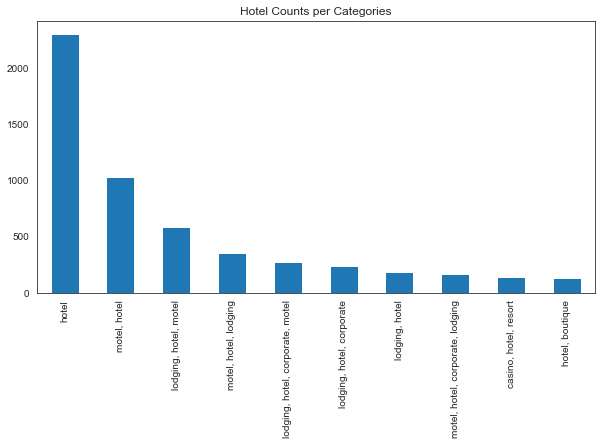

In [31]:
# List of Categories 
plt.figure(figsize=(10, 5))
df.clean_categories.value_counts().head(10).plot(kind='bar')
plt.title('Hotel Counts per Categories')
plt.show()

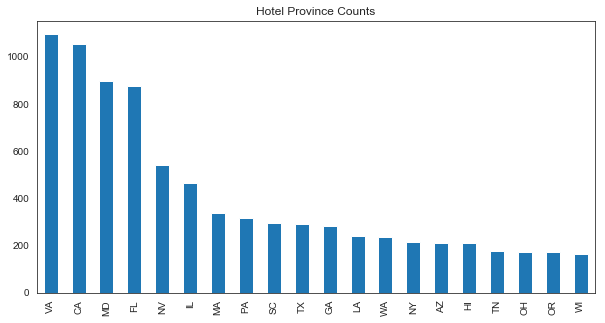

In [32]:
plt.figure(figsize=(10, 5))
df.province.value_counts().head(20).plot(kind='bar')
plt.title('Hotel Province Counts')
plt.show()

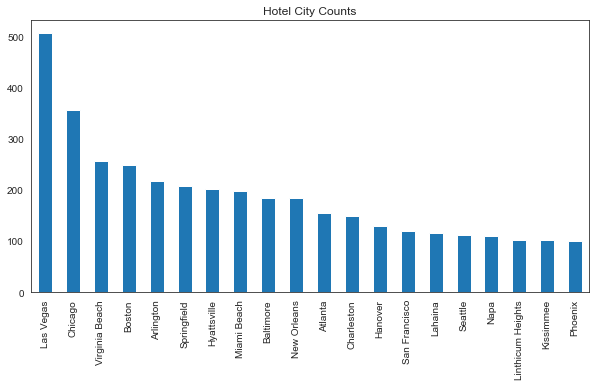

In [33]:
plt.figure(figsize=(10, 5))
df.city.value_counts().head(20).plot(kind='bar')
plt.title('Hotel City Counts')
plt.show()

The Top 4 Cities with the most Hotels 
* Las Vegas 
* Chicago 
* Virginia Beach
* Boston

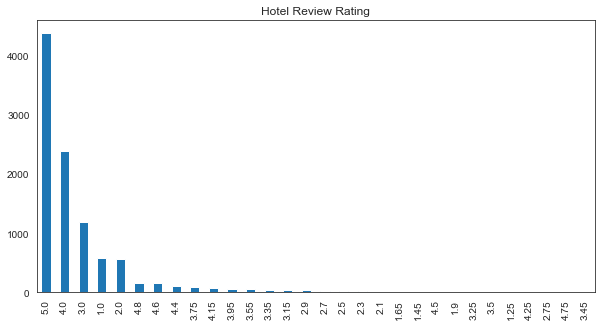

In [34]:
# List of Categories 
plt.figure(figsize=(10, 5))
df.reviews_rating.value_counts().plot(kind='bar')
plt.title('Hotel Review Rating')
plt.show()

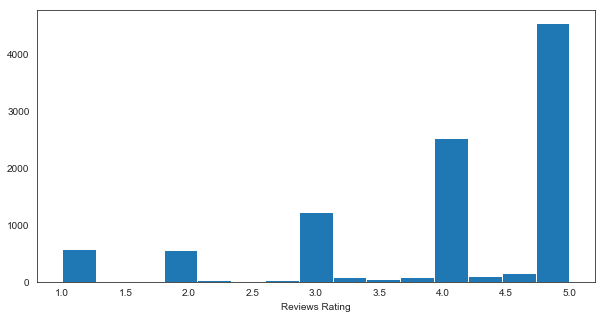

In [35]:
plt.figure(figsize=(10, 5))
plt.hist(df['reviews_rating'], bins = 15) 
plt.xlabel('Reviews Rating')
plt.show()

Here we see that the data has way more reviews that are above 3 stars.  
So we will divide our data set into 2 categories:
* less and equal to 3 stars 
* greater than 3 stars

So we will studies those reviews and see if there is a pattern.  
Similar to sentiment to analysis.   

In [36]:
df = df[df['reviews_rating']>=4]
display(df.head(1))

,reviews_rating,reviews_title,reviews_text,hotel_name,clean_categories,primary_categories,address,city,province,country,postalcode,latitude,longitude,dateadded,dateupdated,reviews_date,reviews_dateseen,reviews_usercity,reviews_userprovince,reviews_username
0,5.0,Best romantic vacation ever!!!!,Our experience at Rancho Valencia was absolute...,Rancho Valencia Resort Spa,"motel, hotel, resort, reservation","accommodation, food",5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2013-11-14,2016-08-03,Rancho Santa Fe,CA,Paula


In [37]:
# Count nulls 
null_count = df.isnull().sum()
null_count[null_count>0]

reviews_title    1
dtype: int64

In [38]:
df.columns

Index(['reviews_rating', 'reviews_title', 'reviews_text', 'hotel_name',
       'clean_categories', 'primary_categories', 'address', 'city', 'province',
       'country', 'postalcode', 'latitude', 'longitude', 'dateadded',
       'dateupdated', 'reviews_date', 'reviews_dateseen', 'reviews_usercity',
       'reviews_userprovince', 'reviews_username'],
      dtype='object')

In [39]:
import folium
from folium import plugins

/anaconda/lib/python3.6/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/anaconda/lib/python3.6/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name


In [40]:
df[['clean_categories','primary_categories', 'city', 'country', 'latitude', 'longitude',
    'hotel_name', 'postalcode', 'province',]].head()

,clean_categories,primary_categories,city,country,latitude,longitude,hotel_name,postalcode,province
0,"motel, hotel, resort, reservation","accommodation, food",Rancho Santa Fe,US,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA
1,"motel, hotel, resort, reservation","accommodation, food",Rancho Santa Fe,US,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA
2,"motel, hotel, resort, reservation","accommodation, food",Rancho Santa Fe,US,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA
4,"agencie, motel, hotel, travel, management, bureau","accommodation, food",Hanover,US,39.155929,-76.716341,Aloft Arundel Mills,21076,MD
5,"agencie, motel, hotel, travel, management, bureau","accommodation, food",Hanover,US,39.155929,-76.716341,Aloft Arundel Mills,21076,MD


### Las Vegas Hotel Locations

In [41]:
df_LV = df[df['city'] =='Las Vegas'][['latitude', 'longitude','hotel_name']]
#df_LV.head()

In [42]:
m_LV = folium.Map([36.099900, -115.182800], zoom_start=11)
#m_LV

In [43]:
# mark each hotel as a point
for index, row in df_LV.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row['hotel_name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m_LV)

In [44]:
# convert to (n, 2) nd-array format for heatmap
Hotel_LV = df_LV[['latitude', 'longitude']].as_matrix()

# plot heatmap
m_LV.add_children(plugins.HeatMap(Hotel_LV, radius=15))
m_LV

### Chicago Hotel Locations

In [45]:
df_CHI = df[df['city'] =='Chicago'][['latitude', 'longitude','hotel_name']]

In [46]:
#df_CHI[(df_CHI['name'] == 'Clarion Inn & Suites')|(df_CHI['name'] == 'Rodeway Inn')].head()

In [47]:
m_CHI = folium.Map([41.904050, -87.705900], zoom_start=11)
#m_CHI

In [48]:
# mark each hotel as a point
for index, row in df_CHI.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row['hotel_name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m_CHI)

In [49]:
# convert to (n, 2) nd-array format for heatmap
Hotel_CHI = df_CHI[['latitude', 'longitude']].as_matrix()

# plot heatmap
m_CHI.add_children(plugins.HeatMap(Hotel_CHI, radius=15))
m_CHI

### Vigirnia Beach Hotel Locations

In [50]:
df_VB = df[df['city'] =='Virginia Beach'][['latitude', 'longitude','hotel_name']]
#df_VB

In [51]:
#df_VB[(df_VB['name'] == 'Best Western Plus Virginia Beach')|(df_VB['name'] == 'Virginia Beach Resort Hotel Conference Center')].tail()

In [52]:
m_VB = folium.Map([36.913202, -76.06851], zoom_start=11)
#m_VB

In [53]:
# mark each hotel as a point
for index, row in df_VB.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row['hotel_name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m_VB)

In [54]:
# convert to (n, 2) nd-array format for heatmap
Hotel_VB = df_VB[['latitude', 'longitude']].as_matrix()

# plot heatmap
m_VB.add_children(plugins.HeatMap(Hotel_CHI, radius=15))
m_VB

### Boston Hotel Locations

In [55]:
df_BOS = df[df['city'] =='Boston'][['latitude', 'longitude','hotel_name']]
#df_BOS

In [56]:
m_BOS = folium.Map([42.356958, -71.052850], zoom_start=11)
#m_BOS

In [57]:
# mark each hotel as a point
for index, row in df_BOS.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row['hotel_name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m_BOS)

In [58]:
# convert to (n, 2) nd-array format for heatmap
Hotel_BOS = df_BOS[['latitude', 'longitude']].as_matrix()

# plot heatmap
m_BOS.add_children(plugins.HeatMap(Hotel_BOS, radius=15))
m_BOS

## Text Analysis 

In [59]:
df['reviews_title'].head()

0    Best romantic vacation ever!!!!
1               Sweet sweet serenity
2    Amazing Property and Experience
4               ALWAYS GREAT STAY...
5                     Wonderful stay
Name: reviews_title, dtype: object

In [60]:
df['reviews_text'].head()

0    Our experience at Rancho Valencia was absolute...
1    Amazing place. Everyone was extremely warm and...
2    We booked a 3 night stay at Rancho Valencia to...
4    I live in Md and the Aloft is my Home away fro...
5    I stayed here with my family for my daughters ...
Name: reviews_text, dtype: object

In [61]:
#Here we clean the reviews by removing all the  punctuation, 
#removing all that is unnecessary.

df['reviews_title'] = df['reviews_title'].str.replace(r'[^a-zA-Z0-9 ]', "",).fillna('')
df['reviews_title'] = df['reviews_title'].str.lower()
df['reviews_text'] = df['reviews_text'].str.replace(r'[^a-zA-Z0-9 ]', "",).fillna('')
df['reviews_text'] = df['reviews_text'].str.lower()

In [62]:
df['reviews_title'].head()

0        best romantic vacation ever
1               sweet sweet serenity
2    amazing property and experience
4                  always great stay
5                     wonderful stay
Name: reviews_title, dtype: object

In [63]:
df['reviews_text'].head()

0    our experience at rancho valencia was absolute...
1    amazing place everyone was extremely warm and ...
2    we booked a 3 night stay at rancho valencia to...
4    i live in md and the aloft is my home away fro...
5    i stayed here with my family for my daughters ...
Name: reviews_text, dtype: object

In [64]:
print('The shape of the data is:', df.shape)
display(df.head(1))

The shape of the data is: (7285, 20)


,reviews_rating,reviews_title,reviews_text,hotel_name,clean_categories,primary_categories,address,city,province,country,postalcode,latitude,longitude,dateadded,dateupdated,reviews_date,reviews_dateseen,reviews_usercity,reviews_userprovince,reviews_username
0,5.0,best romantic vacation ever,our experience at rancho valencia was absolute...,Rancho Valencia Resort Spa,"motel, hotel, resort, reservation","accommodation, food",5921 Valencia Cir,Rancho Santa Fe,CA,US,92067,32.990959,-117.186136,2016-10-30,2018-09-10,2013-11-14,2016-08-03,Rancho Santa Fe,CA,Paula


## Most frequent words in the data

In [65]:
# function to plot most frequent terms 
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
  
    fdist = FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()),   
              'count':list(fdist.values())}) 
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms)      
    plt.figure(figsize=(20,5)) 
    ax = sns.barplot(data=d, x= "word", y = "count") 
    ax.set(ylabel = 'Count') 
    plt.show()

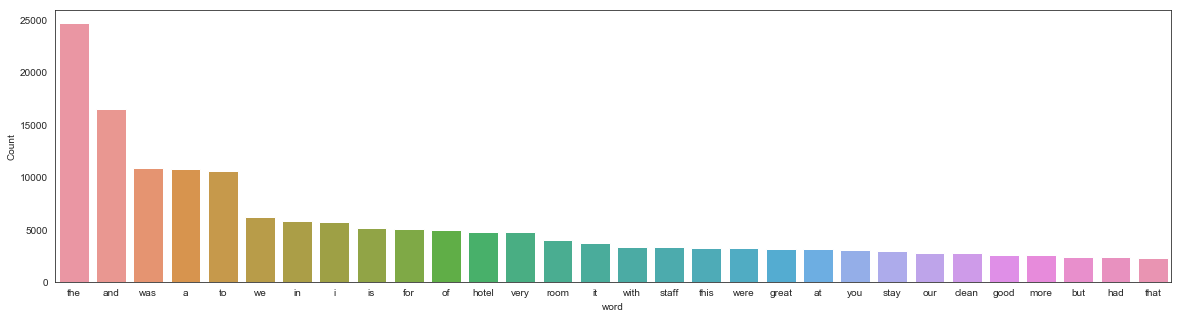

In [66]:
freq_words(df['reviews_text'])

We note that some of them are __stopwords__.   
These words are not so important for our task and they do not tell any story. We are going to get rid of these kinds of words. 

In [67]:
## Remove StopWords

In [68]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')
# function to remove stopwords 
def remove_stopwords(rev):     
    rev_new = " ".join([i for i in rev if i not in stop_words])      
    return rev_new 
# remove short words (length < 3) 
df['reviews_text'] = df['reviews_text'].apply(lambda x: ' '.join([w for 
                   w in x.split() if len(w)>2])) 
# remove stopwords from the text 
reviews = [remove_stopwords(r.split()) for r in df['reviews_text']] 
# make entire text lowercase 
reviews = [r.lower() for r in reviews]

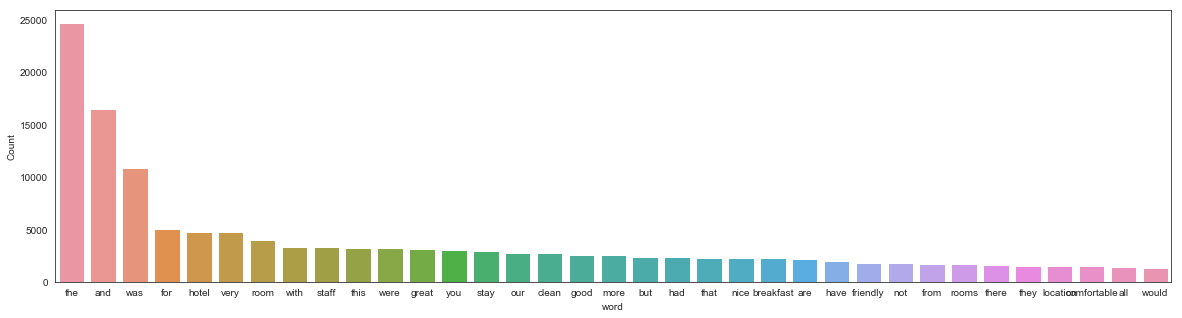

In [69]:
#plot the most frequent words
plt.figure(figsize=(10, 15))
freq_words(df['reviews_text'], 35)

This is better, we see words like:  
* staff 
* nice 
* breakfast 
* family
* clean 
* rooms etc... 
The presence of those words make sense since the data set is one in which reviews of hotels are provided.  

In [70]:
!python -m spacy download en #one time run
nlp = spacy.load('en', disable=['parser', 'ner']) 

def lemmatization(texts, tags=['NOUN', 'ADJ']): 
    output = []        
    for sent in texts:              
        doc = nlp(" ".join(sent))                             
        output.append([token.lemma_ for token in doc if 
        token.pos_ in tags])        
    return output

    100% |████████████████████████████████| 37.4MB 11.6MB/s ta 0:00:01  10% |███▏                            | 3.7MB 5.2MB/s eta 0:00:07    11% |███▊                            | 4.3MB 5.0MB/s eta 0:00:07
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /anaconda/lib/python3.6/site-packages/en_core_web_sm -->
    /anaconda/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [71]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['amazing', 'place', 'everyone', 'extremely', 'warm', 'welcoming', 'weve', 'stayed', 'top', 'notch', 'places', 'definitely', 'top', 'great', 'romantic', 'getaway', 'take', 'kids', 'along', 'couple', 'stuffed', 'animals', 'waiting', 'girls', 'upon', 'arrival', 'cant', 'wait', 'back']


In [72]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['amazing', 'place', 'everyone', 'warm', 'top', 'notch', 'place', 'great', 'romantic', 'getaway', 'kid', 'couple', 'animal', 'girl', 'arrival']


We have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized reviews and plot the most common words.

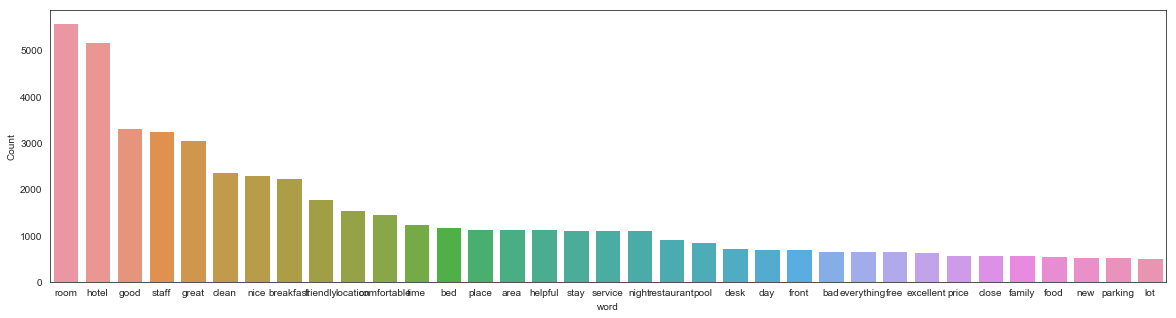

In [73]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

Now the most common words in our data are words that are relevant to what we are looking to do. 

## Sentiment Classification 

In [74]:
#we remove neutral score 3, then group score 4 and 5 to positive (1), 
#and score 1 and 2 to negative (0)

#df[df['reviews_rating'] != 3]
#df['positivity'] = np.where(df['reviews_rating'] > 3, 1, 0)


## What Amenities do reviewer found positive in the Hotels in Particular states. 
## Visualization: States with more positive reviews and states reviews

In [75]:
df.head(1)

,reviews_rating,reviews_title,reviews_text,hotel_name,clean_categories,primary_categories,address,city,province,country,...,latitude,longitude,dateadded,dateupdated,reviews_date,reviews_dateseen,reviews_usercity,reviews_userprovince,reviews_username,reviews
0,5.0,best romantic vacation ever,our experience rancho valencia was absolutely ...,Rancho Valencia Resort Spa,"motel, hotel, resort, reservation","accommodation, food",5921 Valencia Cir,Rancho Santa Fe,CA,US,...,32.990959,-117.186136,2016-10-30,2018-09-10,2013-11-14,2016-08-03,Rancho Santa Fe,CA,Paula,experience rancho valencia perfect beginning e...


## Create Training and Test Set

In [76]:
## Looking at what people like compare to where the city they are going to is located 
## String substitution 
## Create a feature that's city_state

## Sentiment Analysis ===> Figure out what are the words that  Don't Do  
## Modeling algorithm tha works with class imbalance 
## What is a bad review ?
## Look at the reviews that ar 3 star review and 4 star review look  like 

## What do people who go to California like ? 
## Topic model of all the reviews that are less than 4 stars
## Look at correlation between Topics and stars 

## Look only at positive reviews Try to predict the state from the words 
## Different reviews look only at the positive ones. Reduce it down to 10 components 
## Use the 10 components 

## 

In [77]:
Y = df['province']
X = df['reviews']

In [78]:
from sklearn.model_selection import train_test_split

#  Create Training and Test Sets
X_train, X_test, Y_train, Y_test, reviews_2_train, reviews_2_test = train_test_split(X, Y, reviews_2, test_size=0.25, random_state=0)

In [79]:
ntopics = 5

In [80]:
dictionary_train = corpora.Dictionary(reviews_2_train)
dictionary_test = corpora.Dictionary(reviews_2_test)

In [81]:
# Create a dictionary of our corpus, where every unique term is assigned an index

In [82]:
doc_term_matrix_train = [dictionary_train.doc2bow(rev) for rev in reviews_2_train]
doc_term_matrix_test = [dictionary_test.doc2bow(rev) for rev in reviews_2_test]

## LDA  and LSI Models

### LDA_Model

In [83]:
t0 = time.clock()
# Creating the object for LDA model using gensim library 
LDA = gensim.models.ldamodel.LdaModel 
# Build LDA model 
lda_model = LDA(corpus=doc_term_matrix_train, id2word=dictionary_train,                                     
                num_topics=ntopics, random_state=100, chunksize=1000,                                     
                passes=50)
print('\nThe LDA_MODEL on Training dataset done in '+'%s seconds'% (time.clock() - t0))


The LDA_MODEL on Training dataset done in 111.652308 seconds


In [84]:
print("LDA Model:")
 
for idx in range(ntopics):
    # Print the first 10 most representative topics
    print("\nTopic #%s:" % idx, lda_model.print_topic(idx, 10))

LDA Model:

Topic #0: 0.074*"room" + 0.021*"bed" + 0.018*"nice" + 0.014*"bathroom" + 0.013*"clean" + 0.012*"hotel" + 0.012*"comfortable" + 0.011*"area" + 0.011*"night" + 0.010*"shower"

Topic #1: 0.031*"hotel" + 0.019*"new" + 0.012*"service" + 0.011*"time" + 0.009*"property" + 0.008*"guest" + 0.008*"room" + 0.008*"review" + 0.007*"stay" + 0.006*"bar"

Topic #2: 0.010*"view" + 0.010*"time" + 0.009*"day" + 0.009*"place" + 0.009*"lovely" + 0.008*"family" + 0.008*"hotel" + 0.007*"fun" + 0.007*"beautiful" + 0.007*"beach"

Topic #3: 0.046*"good" + 0.044*"room" + 0.043*"hotel" + 0.033*"staff" + 0.032*"great" + 0.030*"breakfast" + 0.027*"clean" + 0.026*"nice" + 0.021*"location" + 0.020*"friendly"

Topic #4: 0.044*"hotel" + 0.031*"staff" + 0.020*"desk" + 0.019*"service" + 0.018*"front" + 0.017*"room" + 0.016*"helpful" + 0.015*"great" + 0.015*"friendly" + 0.015*"time"


In [85]:
## word lists
for i in range(0,ntopics):
    temp = lda_model.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term)
    print("\nTop 10 terms for topic #" + str(i) + ": "+ ", ".join([i[0] for i in terms]))
   


Top 10 terms for topic #0: room, bed, nice, bathroom, clean, hotel, comfortable, area, night, shower

Top 10 terms for topic #1: hotel, new, service, time, property, guest, room, review, stay, bar

Top 10 terms for topic #2: view, time, day, place, lovely, family, hotel, fun, beautiful, beach

Top 10 terms for topic #3: good, room, hotel, staff, great, breakfast, clean, nice, location, friendly

Top 10 terms for topic #4: hotel, staff, desk, service, front, room, helpful, great, friendly, time


In [86]:
# Visualize the topics 
pyLDAvis.enable_notebook() 
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix_train,  
                              dictionary_train) 
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.174286 -0.051333       1        1  44.491161
4     -0.052389 -0.137720       2        1  18.071932
0     -0.133022  0.164504       3        1  16.162996
1      0.174379 -0.107094       4        1  11.168239
2      0.185318  0.131644       5        1  10.105674, topic_info=     Category         Freq         Term        Total  loglift  logprob
19    Default  3887.000000         room  3887.000000  30.0000  30.0000
35    Default  2405.000000         good  2405.000000  29.0000  29.0000
22    Default  2275.000000        staff  2275.000000  28.0000  28.0000
5     Default  1597.000000    breakfast  1597.000000  27.0000  27.0000
30    Default   846.000000          bed   846.000000  26.0000  26.0000
41    Default  1652.000000         nice  1652.000000  25.0000  25.0000
14    Default  1249.000000     friendly  1249.000000  24.0000  24.0000
63    Default   526.000000         desk   526.000000  23.0000  23.0000
54    Default   799.000000      helpful   799.000000  22.0000  22.0000
70    Default   497.000000        front   497.000000  21.0000  21.0000
324   Default   356.000000          new   356.000000  20.0000  20.0000
117   Default   767.000000      service   767.000000  19.0000  19.0000
16    Default  3658.000000        hotel  3658.000000  18.0000  18.0000
8     Default  1008.000000  comfortable  1008.000000  17.0000  17.0000
7     Default  1668.000000        clean  1668.000000  16.0000  16.0000
37    Default  1104.000000     location  1104.000000  15.0000  15.0000
288   Default   308.000000     bathroom   308.000000  14.0000  14.0000
351   Default   230.000000      shuttle   230.000000  13.0000  13.0000
29    Default   497.000000          bad   497.000000  12.0000  12.0000
20    Default   182.000000       shower   182.000000  11.0000  11.0000
365   Default   414.000000        price   414.000000  10.0000  10.0000
88    Default   895.000000         time   895.000000   9.0000   9.0000
60    Default   798.000000         area   798.000000   8.0000   8.0000
498   Default   338.000000        suite   338.000000   7.0000   7.0000
270   Default   325.000000         view   325.000000   6.0000   6.0000
180   Default   337.000000        small   337.000000   5.0000   5.0000
197   Default   242.000000        large   242.000000   4.0000   4.0000
177   Default   576.000000         pool   576.000000   3.0000   3.0000
282   Default   290.000000     property   290.000000   2.0000   2.0000
289   Default   285.000000    beautiful   285.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
183    Topic5    47.098270          air    75.116501   1.8253  -5.4649
316    Topic5    46.318096        house    79.022949   1.7579  -5.4816
1946   Topic5    46.399963         game    80.669334   1.7390  -5.4798
1646   Topic5    32.407818         plan    49.587414   1.8667  -5.8387
588    Topic5    28.360561     gorgeous    40.883728   1.9263  -5.9721
270    Topic5   110.618538         view   325.775360   1.2120  -4.6110
494    Topic5    41.434418        ocean    73.238045   1.7225  -5.5930
363    Topic5    26.979887     mountain    38.993660   1.9238  -6.0220
222    Topic5    79.883812        beach   242.814087   1.1804  -4.9365
840    Topic5    36.399136        group    64.896416   1.7138  -5.7225
289    Topic5    80.417839    beautiful   285.271759   1.0259  -4.9299
65     Topic5    91.623650       family   415.087189   0.7813  -4.7994
378    Topic5    96.496750          day   506.861694   0.6333  -4.7476
352    Topic5    51.867096        space   153.642929   1.2061  -5.3684
47     Topic5    60.237411       street   215.377884   1.0180  -5.2188
88     Topic5   110.285210         time   895.273621   0.1980  -4.6140
508    Topic5    68.012177      perfect   340.840485   0.6803  -5.0974
84     Topic5    95.080467        place   783.046814   0.1836  -4.7624
83     Topic5    42.420353   

### LSI_Model

In [87]:
t0 = time.clock()
# Creating the object for LSI model using gensim library 
LSI = gensim.models.lsimodel.LsiModel 
# Build LSI model 
lsi_model = LSI(corpus=doc_term_matrix_train, id2word=dictionary_train,                                     
                num_topics=ntopics, chunksize=1000)
print('\nThe LSI_MODEL on Training dataset done in '+'%s seconds'% (time.clock() - t0))


The LSI_MODEL on Training dataset done in 3.072956000000005 seconds


In [88]:
print("LSI Model:")
 
for idx in range(ntopics):
    # Print the first 10 most representative topics
    print("\nTopic #%s:" % idx, lsi_model.print_topic(idx, 10))

LSI Model:

Topic #0: 0.510*"room" + 0.495*"hotel" + 0.241*"good" + 0.241*"staff" + 0.225*"great" + 0.181*"nice" + 0.174*"clean" + 0.169*"breakfast" + 0.130*"friendly" + 0.112*"location"

Topic #1: 0.757*"hotel" + -0.586*"room" + -0.114*"clean" + -0.100*"bed" + -0.096*"nice" + -0.082*"breakfast" + -0.071*"comfortable" + -0.045*"good" + 0.042*"time" + 0.041*"restaurant"

Topic #2: -0.626*"good" + 0.491*"room" + 0.295*"hotel" + -0.270*"great" + -0.236*"breakfast" + -0.225*"staff" + -0.149*"location" + -0.118*"friendly" + -0.095*"bad" + -0.069*"place"

Topic #3: 0.775*"great" + -0.533*"good" + 0.134*"staff" + -0.133*"hotel" + -0.103*"room" + 0.089*"time" + 0.082*"place" + 0.068*"stay" + 0.064*"location" + 0.064*"service"

Topic #4: -0.416*"staff" + -0.385*"nice" + -0.378*"clean" + 0.372*"good" + 0.299*"great" + -0.267*"friendly" + 0.206*"service" + 0.191*"room" + -0.155*"breakfast" + -0.119*"helpful"


In [89]:
## word lists
for i in range(0, ntopics):
    temp = lsi_model.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term)
    print("\nTop 10 terms for topic #" + str(i) + ": "+ ", ".join([i[0] for i in terms]))


Top 10 terms for topic #0: room, hotel, good, staff, great, nice, clean, breakfast, friendly, location

Top 10 terms for topic #1: hotel, room, clean, bed, nice, breakfast, comfortable, good, time, restaurant

Top 10 terms for topic #2: good, room, hotel, great, breakfast, staff, location, friendly, bad, place

Top 10 terms for topic #3: great, good, staff, hotel, room, time, place, stay, location, service

Top 10 terms for topic #4: staff, nice, clean, good, great, friendly, service, room, breakfast, helpful


## Create Features Using tf-idf

### Create Vectorizer for Text Reviews

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Extracting features from the reviews_text in dataset using a vectorizer")
t0 = time.clock()
Xvectorizer = TfidfVectorizer(max_df=.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             ngram_range=(1, 3)
                             )

#Find Vocab words on the whole articles 
#Applying the vectorizer to X_train and X_test
X_train_tfidf=Xvectorizer.fit_transform(X_train)
X_test_tfidf=Xvectorizer.transform(X_test)
vocab = Xvectorizer.vocabulary_

print('\nXvectorizer on reviews_text in the dataset done in '+'%s seconds'% (time.clock() - t0))

Extracting features from the reviews_text in dataset using a vectorizer

Xvectorizer on reviews_text in the dataset done in 1.6835080000000175 seconds


In [91]:
X_train.head(1)

7850    indigo trip advisor unique boutique type hotel...
Name: reviews, dtype: object

In [92]:
Y_train.head(1)

7850    PA
Name: province, dtype: object

In [93]:

terms = Xvectorizer.get_feature_names()
#ntopics = 5, 10, 20, 50, 100 ===> Pipeline

## LDA and LSI Using Vectorizer 

In [94]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

In [95]:
#inferred topics we need to implement a print function 

In [96]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

### LDA

In [97]:
t0 = time.clock()
lda = LatentDirichletAllocation(ntopics, max_iter=10, learning_method='online')


X_train_lda = lda.fit_transform(X_train_tfidf)
X_test_lda = lda.transform(X_test_tfidf)

print('LDA done in '+'%s seconds'% (time.clock() - t0))

LDA done in 10.319249000000013 seconds


In [98]:
print('The shape of X_train_lsa is:', X_train_lda.shape)
print('The shape of X_test_lsa is:', X_test_lda.shape)

The shape of X_train_lsa is: (5463, 5)
The shape of X_test_lsa is: (1822, 5)


In [99]:
#Looking at what sorts of titles our solution considers similar, for the first five identified topics
print('For the Training set:')
titles1_by_component_LDA=pd.DataFrame(X_train_lda,index=X_train.index)
for i in range(5):
    print('Component {}:'.format(i))
    print(titles1_by_component_LDA.loc[:,i].sort_values(ascending=False)[0:3])
    
print('\nFor the Test set:')    

titles2_by_component_LDA=pd.DataFrame(X_test_lda,index=X_test.index)
for i in range(5):
    print('Component {}:'.format(i))
    print(titles2_by_component_LDA.loc[:,i].sort_values(ascending=False)[0:3])

For the Training set:
Component 0:
390     0.941724
1920    0.939225
1747    0.939164
Name: 0, dtype: float64
Component 1:
5590    0.821100
5631    0.818007
5591    0.814659
Name: 1, dtype: float64
Component 2:
2683    0.679995
2681    0.679995
4283    0.599868
Name: 2, dtype: float64
Component 3:
1707    0.631250
1700    0.596621
1769    0.576505
Name: 3, dtype: float64
Component 4:
1474    0.738873
1482    0.680382
1480    0.671342
Name: 4, dtype: float64

For the Test set:
Component 0:
4847    0.923446
1854    0.921258
1733    0.920451
Name: 0, dtype: float64
Component 1:
3073    0.668522
4625    0.652662
5788    0.598288
Name: 1, dtype: float64
Component 2:
5074    0.2
4463    0.2
5586    0.2
Name: 2, dtype: float64
Component 3:
1743    0.523125
1768    0.471118
1756    0.449019
Name: 3, dtype: float64
Component 4:
1459    0.739493
1463    0.655289
1491    0.619442
Name: 4, dtype: float64


In [100]:
print('The Components Value per Reviews using LDA are:')
titles1_by_component_LDA.head()

The Components Value per Reviews using LDA are:


,0,1,2,3,4
7850,0.892518,0.026858,0.026859,0.026856,0.026909
1007,0.877830,0.030542,0.030543,0.030541,0.030545
7014,0.875390,0.031153,0.031153,0.031152,0.031152
9087,0.879561,0.030111,0.030112,0.030107,0.030109
8433,0.823036,0.044242,0.044243,0.044239,0.044240


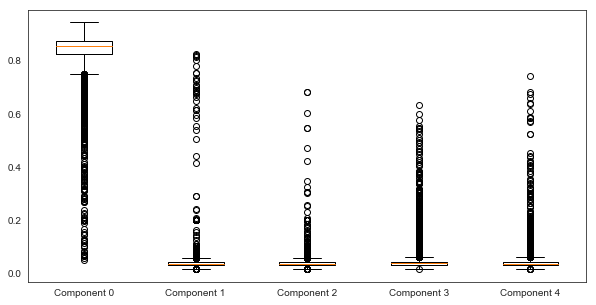

In [101]:
plt.figure(figsize=(10, 5))
plt.boxplot([titles1_by_component_LDA[0].values, titles1_by_component_LDA[1].values, titles1_by_component_LDA[2].values, titles1_by_component_LDA[3].values, titles1_by_component_LDA[4].values])
plt.xticks([1, 2, 3, 4, 5], ['Component 0', 'Component 1','Component 2','Component 3', 'Component 4'])
plt.show()

In [102]:
Component_train_LDA = pd.DataFrame()
Component_train_LDA['Reviews'] = X_train
Component_train_LDA['component'] = titles1_by_component_LDA.idxmax(axis=1)

In [103]:
Component_test_LDA = pd.DataFrame()
Component_test_LDA['Reviews'] = X_test
Component_test_LDA['component'] = titles2_by_component_LDA.idxmax(axis=1)

In [104]:
X_train_component_LDA = Component_train_LDA['component']
X_test_component_LDA = Component_test_LDA['component']

In [105]:
Component_train_LDA.head()

,Reviews,component
7850,indigo trip advisor unique boutique type hotel...,0
1007,bad person touch familiar jokey reception prob...,0
7014,hotel spring break night staff friendly helpfu...,0
9087,family freehold friend favorite spot federicis...,0
8433,food amazing staff everything accommodate part...,0


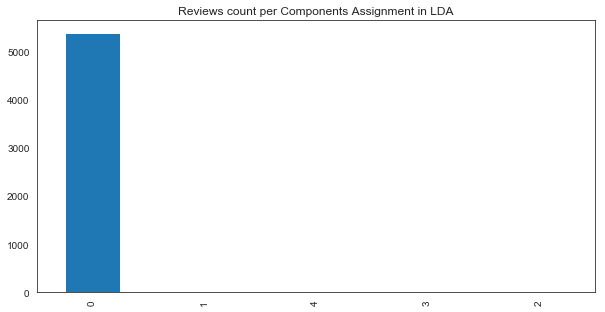

In [106]:
plt.figure(figsize=(10, 5))
Component_train_LDA.component.value_counts().plot(kind='bar')
plt.title('Reviews count per Components Assignment in LDA')
plt.show()

In [107]:
print('\nThe shape of X_train_tfidf for Reviews is:', X_train_tfidf.shape)
Component_train_LDA.component.value_counts()


The shape of X_train_tfidf for Reviews is: (5463, 17738)


0    5389
1      32
4      18
3      17
2       7
Name: component, dtype: int64

In [108]:
tf_vectorizer = CountVectorizer(max_features=10,
                                stop_words='english')
t0 = time.clock()

print("Top terms per components:") 
for i in range(5):
    tf = tf_vectorizer.fit_transform(Component_train_LDA.loc[Component_train_LDA['component'] == i,'Reviews'])
    print('\ntf_vectorizer on done in '+'%s seconds'% (time.clock() - t0))
    print("\nTopics in Component ", i)
    tf_feature_names = tf_vectorizer.get_feature_names()
    print(tf_feature_names)

Top terms per components:

tf_vectorizer on done in 0.24085900000000038 seconds

Topics in Component  0
['breakfast', 'clean', 'friendly', 'good', 'great', 'hotel', 'location', 'nice', 'room', 'staff']

tf_vectorizer on done in 0.24936300000001665 seconds

Topics in Component  1
['avon', 'chambre', 'das', 'estacion', 'hotel', 'muy', 'nous', 'para', 'room', 'washington']

tf_vectorizer on done in 0.2555670000000134 seconds

Topics in Component  2
['bad', 'card', 'clean', 'day', 'door', 'helpful', 'noisy', 'oil', 'pleasent', 'room']

tf_vectorizer on done in 0.26042400000000043 seconds

Topics in Component  3
['experience', 'good', 'guest', 'hotel', 'location', 'new', 'recent', 'room', 'seattle', 'stay']

tf_vectorizer on done in 0.266475000000014 seconds

Topics in Component  4
['anaheim', 'angel', 'feedback', 'great', 'hope', 'hotel', 'maingate', 'room', 'stay', 'suite']


In [109]:
print("LDA Model:")
print_topics(lda, Xvectorizer)


LDA Model:
Topic 0:
[('hotel', 205.15636155427245), ('good', 178.09823894547858), ('great', 163.10255813162388), ('staff', 147.81856382482619), ('nice', 129.35807910052765), ('clean', 123.11116144468909), ('breakfast', 117.67033983651821), ('friendly', 105.03823470077431), ('location', 95.529344123823293), ('comfortable', 89.375871155569968)]
Topic 1:
[('muy', 4.1737511473465636), ('sehr', 2.189550777715906), ('para', 2.1558868342384119), ('nous', 1.8579153293869581), ('una', 1.6992045893647025), ('das', 1.6480013606014812), ('washington', 1.5875551106152124), ('estacion', 1.5152912591582197), ('todo', 1.426985832086501), ('buena', 1.4025720831884139)]
Topic 2:
[('good bang buck', 1.6871302520408122), ('good bang', 1.6871238004435707), ('bang buck', 1.6871156104864797), ('parking fee', 1.6862825687770631), ('good amenity', 1.6628328916706439), ('sound proof', 1.5695294265670139), ('proof', 1.5695285788079754), ('colazione', 1.2461394714032348), ('pricey good', 1.1618015326944624), ('sp

In [110]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda,X_train_tfidf, Xvectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -193.911811  418.260175       1        1  84.093406
3      176.298194 -365.759705       2        1   4.452979
4      190.083394  -88.711948       3        1   4.169470
1      -26.262490   73.821901       4        1   3.725028
2     -133.461906 -196.345000       5        1   3.559117, topic_info=      Category        Freq                        Term       Total  loglift  \
7679   Default  155.000000                       hotel  155.000000  30.0000   
6165   Default  134.000000                        good  134.000000  29.0000   
6626   Default  123.000000                       great  123.000000  28.0000   
15080  Default  111.000000                       staff  111.000000  27.0000   
10504  Default   98.000000                        nice   98.000000  26.0000   
2561   Default   93.000000                       clean   93.000000  25.0000   
17175  Default    3.000000                  washington    3.000000  24.0000   
1624   Default   89.000000                   breakfast   89.000000  23.0000   
9315   Default    1.000000           location friendly    1.000000  22.0000   
6293   Default    1.000000               good friendly    1.000000  21.0000   
5769   Default   79.000000                    friendly   79.000000  20.0000   
16629  Default    3.000000                 tripadvisor    3.000000  19.0000   
10322  Default    1.000000                         muy    1.000000  18.0000   
11649  Default    4.000000                    personal    4.000000  17.0000   
7258   Default    1.000000                      hassle    1.000000  16.0000   
4867   Default    1.000000  excellent customer service    1.000000  15.0000   
4866   Default    1.000000          excellent customer    1.000000  14.0000   
9317   Default    1.000000     location friendly staff    1.000000  13.0000   
9246   Default   72.000000                    location   72.000000  12.0000   
405    Default    1.000000                       angel    1.000000  11.0000   
6294   Default    1.000000         good friendly staff    1.000000  10.0000   
393    Default    1.000000                     anaheim    1.000000   9.0000   
15070  Default    2.000000                     stadium    2.000000   8.0000   
6408   Default    1.000000                good perfect    1.000000   7.0000   
6814   Default    1.000000     great location friendly    1.000000   6.0000   
9350   Default    1.000000           location location    1.000000   5.0000   
3082   Default   67.000000                 comfortable   67.000000   4.0000   
6958   Default    1.000000        great staff friendly    1.000000   3.0000   
9494   Default    1.000000                         los    1.000000   2.0000   
800    Default    1.000000          bad breakfast good    1.000000   1.0000   
...        ...         ...                         ...         ...      ...   
6179    Topic5    0.430272                   good bang    0.754509   2.7740   
911     Topic5    0.430270                   bang buck    0.754513   2.7740   
6172    Topic5    0.424078                good amenity    0.767998   2.7418   
14891   Topic5    0.400282                 sound proof    0.726896   2.7390   
12403   Topic5    0.400282                       proof    0.726896   2.7390   
11411   Topic5    0.430058                 parking fee    0.829671   2.6785   
3037    Topic5    0.317807                   colazione    0.657387   2.6088   
12301   Topic5    0.296298                 pricey good    0.644616   2.5584   
15016   Topic5    0.274450                    spending    0.598681   2.5557   
15017   Topic5    0.274448                spending day    0.598684   2.5557   
9152    Topic5    0.273274          little pricey good    0.600165   2.5489   
5767    Topic5    0.253986       friendliness employee    0.575107   2.5184   
14756   Topic5    0.239784                 small large    0.568325   2.4727

### LSI

In [111]:
#Our SVD data reducer.  We are going to reduce the feature space from 84939 to 1000.
t0 = time.clock()
lsi= TruncatedSVD(ntopics, random_state = 0)
#lsa = make_pipeline(svd, Normalizer(copy=False))


# Run SVD on the training data, then project the training data.
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)

print('LSI done in '+'%s seconds'% (time.clock() - t0))


LSI done in 0.3382930000000215 seconds


In [112]:
print('The shape of X_train_lsi is:', X_train_lsi.shape)
print('The shape of X_test_lsi is:', X_test_lsi.shape)

The shape of X_train_lsi is: (5463, 5)
The shape of X_test_lsi is: (1822, 5)


In [113]:
#Looking at what sorts of titles our solution considers similar, for the first five identified topics
print('For the Training set:')
titles1_by_component_LSI=pd.DataFrame(X_train_lsi,index=X_train.index)
for i in range(5):
    print('Component {}:'.format(i))
    print(titles1_by_component_LSI.loc[:,i].sort_values(ascending=False)[0:3])
    
print('\nFor the Test set:')    

titles2_by_component_LSI=pd.DataFrame(X_test_lsi,index=X_test.index)
for i in range(5):
    print('Component {}:'.format(i))
    print(titles2_by_component_LSI.loc[:,i].sort_values(ascending=False)[0:3])

For the Training set:
Component 0:
5557    0.319675
9404    0.282944
487     0.282944
Name: 0, dtype: float64
Component 1:
487    0.685603
459    0.685603
570    0.685603
Name: 1, dtype: float64
Component 2:
2674    0.682493
6617    0.682493
4234    0.682493
Name: 2, dtype: float64
Component 3:
3281    0.382002
5775    0.362292
3565    0.356939
Name: 3, dtype: float64
Component 4:
9229    0.458962
5677    0.458962
3092    0.458962
Name: 4, dtype: float64

For the Test set:
Component 0:
7731    0.285115
674     0.282944
9075    0.282944
Name: 0, dtype: float64
Component 1:
698     0.685603
674     0.685603
9075    0.685603
Name: 1, dtype: float64
Component 2:
7327    0.682493
9784    0.682493
5249    0.317253
Name: 2, dtype: float64
Component 3:
3486    0.387404
5546    0.271897
3284    0.266423
Name: 3, dtype: float64
Component 4:
5465    0.458962
1994    0.458962
3198    0.458962
Name: 4, dtype: float64


In [114]:
print('The Components Value per Reviews using LSI are:')
titles1_by_component_LSI.head()

The Components Value per Reviews using LSI are:


,0,1,2,3,4
7850,0.154890,-0.047720,-0.010054,0.022702,-0.014881
1007,0.119825,0.088331,0.009862,-0.028069,0.085358
7014,0.217828,-0.084835,-0.096491,0.125466,-0.069575
9087,0.104765,-0.030879,-0.053274,-0.058266,0.007322
8433,0.071298,-0.018726,-0.005727,0.010636,-0.028096


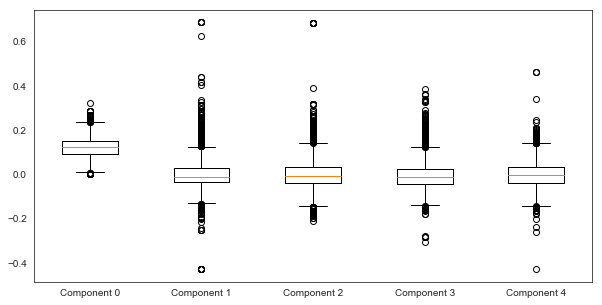

In [115]:
plt.figure(figsize=(10, 5))
plt.boxplot([titles1_by_component_LSI[0].values, titles1_by_component_LSI[1].values, titles1_by_component_LSI[2].values, titles1_by_component_LSI[3].values, titles1_by_component_LSI[4].values])
plt.xticks([1, 2, 3, 4, 5], ['Component 0', 'Component 1','Component 2','Component 3', 'Component 4'])
plt.show()

In [116]:
Component_train_LSI = pd.DataFrame()
Component_train_LSI['reviews'] = X_train
Component_train_LSI['component'] = titles1_by_component_LSI.idxmax(axis=1)

In [117]:
Component_test_LSI = pd.DataFrame()
Component_test_LSI['reviews'] = X_test
Component_test_LSI['component'] = titles2_by_component_LSI.idxmax(axis=1)

In [118]:
X_train_component_LSI = Component_train_LSI['component']
X_test_component_LSI = Component_test_LSI['component']

In [119]:
Component_train_LSI.head()

,reviews,component
7850,indigo trip advisor unique boutique type hotel...,0
1007,bad person touch familiar jokey reception prob...,0
7014,hotel spring break night staff friendly helpfu...,0
9087,family freehold friend favorite spot federicis...,0
8433,food amazing staff everything accommodate part...,0


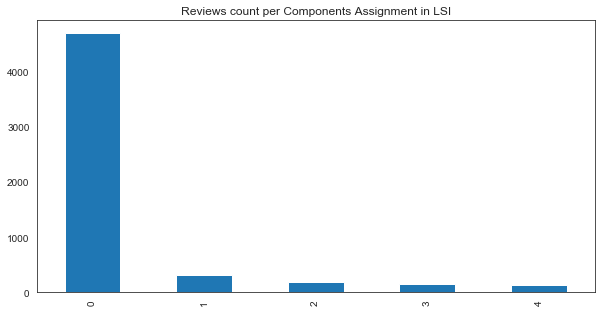

In [120]:
plt.figure(figsize=(10, 5))
Component_train_LSI.component.value_counts().plot(kind='bar')
plt.title('Reviews count per Components Assignment in LSI')
plt.show()

In [121]:
print('\nThe shape of X_train_tfidf for Reviews is:', X_train_tfidf.shape)
Component_train_LSI.component.value_counts()


The shape of X_train_tfidf for Reviews is: (5463, 17738)


0    4704
1     308
2     186
3     140
4     125
Name: component, dtype: int64

In [122]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_features=10,
                                stop_words='english')
t0 = time.clock()

print("Top terms per components:") 
for i in range(5):
    tf = tf_vectorizer.fit_transform(Component_train_LSI.loc[Component_train_LSI['component'] == i,'reviews'])
    print('\ntf_vectorizer on done in '+'%s seconds'% (time.clock() - t0))
    print("\nTopics in Component ", i)
    tf_feature_names = tf_vectorizer.get_feature_names()
    print(tf_feature_names)

Top terms per components:

tf_vectorizer on done in 0.17644500000000107 seconds

Topics in Component  0
['breakfast', 'clean', 'friendly', 'good', 'great', 'hotel', 'location', 'nice', 'room', 'staff']

tf_vectorizer on done in 0.18801200000001472 seconds

Topics in Component  1
['bad', 'bed', 'breakfast', 'good', 'hotel', 'location', 'parking', 'price', 'room', 'staff']

tf_vectorizer on done in 0.19580300000001216 seconds

Topics in Component  2
['bad', 'breakfast', 'good', 'great', 'hotel', 'location', 'place', 'room', 'service', 'stay']

tf_vectorizer on done in 0.20452799999998206 seconds

Topics in Component  3
['breakfast', 'clean', 'friendly', 'good', 'great', 'helpful', 'hotel', 'location', 'room', 'staff']

tf_vectorizer on done in 0.21300400000001218 seconds

Topics in Component  4
['bed', 'breakfast', 'clean', 'comfortable', 'great', 'nice', 'night', 'place', 'pool', 'room']


In [123]:
print("LSI Model:")
print_topics(lsi, Xvectorizer)


LSI Model:
Topic 0:
[('hotel', 0.31967455429172204), ('good', 0.2829438142961414), ('great', 0.26637142222418808), ('staff', 0.23373327324948998), ('nice', 0.20514001968366971), ('clean', 0.1914444703072456), ('breakfast', 0.18250306760840915), ('friendly', 0.16965454265157179), ('location', 0.1482070652518642), ('comfortable', 0.13714385980446395)]
Topic 1:
[('good', 0.68560341655244705), ('bad', 0.31511816856600144), ('good location', 0.15678798692431745), ('bad good', 0.10459367202389777), ('location', 0.092183687719974344), ('breakfast', 0.086405933316932054), ('breakfast good', 0.085196497186915618), ('good breakfast', 0.069665792748615674), ('good good', 0.065576244315946219), ('room good', 0.050594587909612264)]
Topic 2:
[('great', 0.68249334147733787), ('good', 0.26408904938720196), ('bad', 0.156394059421648), ('location', 0.13805634997276034), ('great location', 0.1020570560282846), ('great stay', 0.084945925959744928), ('good great', 0.080672537023772764), ('good location', 0

In [124]:
## Do the component part 
## Advanced NLP ===> Read that very carefully 
## Advanced Text Extraction/ How to choose which ma